In [1]:
%%time

import os
import numpy as np
import pandas as pd

# Commonly-changed parameters

#    Physical setup
e0 = 0.06         # mean eccentricity of initial belt
e0_std = 0.002    # standard deviation
m0 = 10            # initial mass in scatter belt in Earth masses
alpha = 11/6      # size distribution power (Dohnanyi Law, 1969)

#    Integration
t_tot = 10e6               # total time of integration
dt_min = 10               # minimum timestep length

rate_cutoff = -10       # log_10(minimum collision rate tracked)
badr_cutoff = 99.5        # percentage of cells allowed to be underresolved

#    Numbers of gridpoints
gps = 80    # gridpoints in sizd
gpe = 100   # gridpoints in ecc. 

# Flag for whether or not we're starting from a frame of a past run
restart = False

if restart == True:  # if so, say which frame
    resdir = 'results/dt-var_alp-1.8_t-10.0Myr_e-100_s-80_e0-0.10_m0-100Me'
    N_input = pd.read_csv('%s/N.csv' %resdir, header=None,index_col=None)
    t_input = pd.read_csv('%s/t.csv' %resdir, header=None,index_col=None)
    
    N = N.to_numpy().reshape(steps,gpe,gps)
    ts = ts.to_numpy()

    frm = -100
    N_start = N_input[frm]
    t_start = t_input[frm]

# Physical parameters
G = 4*np.pi**2           # grav constant in au^3 solar mass^-1 yr^-2
sma = 45                 # semimajor axis in au
dlt = 4                  # delta_a, width of debris disk in au
per = np.sqrt(sma**3)    # period in yr
frq = 1/per              # frequency in yr^-1
rho = 1                  # density of objects in g cm^-3
r_s = 7e10               # solar radius in cm
sma_cm = sma*1.5e13      # semimajor axis in cm
dlt_cm = dlt*1.5e13      # delta_a in m
alp_sun = r_s/(sma_cm)   # alpha, defined in Goldreich et al as solar radius / SMA
v_kep = np.sqrt(G/sma) * (1.5e13/3.15e7)     # keplerian velocity in cm s^-1

# Breaking energy law constants
A_stg = 2e7       # strength constant A in erg g^-1
B_stg = 3.3e-8    # strength constant B
s0 = 0            # size_0 of strength eq (1 cm in log cm)
alp_stg = -0.3    # strength constant alpha
bet_stg = 2       # strength constant beta

# Parameters of grids
sMin = -4         # log sizes [cm]
sMax = 8

eMin = 0          # eccentricities 
if isinstance(e0,tuple) == True:
    eMax = max(e0)+.05
else:
    eMax = e0+.05

num_colls = gps*gpe*gpe    # number of total possible collisions

# Grid creation
size = np.linspace(sMin,sMax,gps)      
eccs = np.linspace(eMin,eMax,gpe)  

asp_rat = (sMax-sMin)/(eMax-eMin)

# Arrays of integration
ts_max = int(1e5)           # maximum number of timesteps
dtp = np.zeros(ts_max)      # array for tracking proposed timestep length
dt = np.zeros(ts_max)       # array for tracking actual timestep length
ts = np.zeros(ts_max)       # array for tracking actual time

N = np.zeros((ts_max,gpe,gps))            # tracking number in each cell
N_i = np.zeros((ts_max,gpe,gps))          # tracking number going into each cell
N_o = np.zeros((ts_max,gpe,gps))          # tracking number going out of each cell
nrem_all = np.zeros((ts_max,num_colls))   # tracking the rate of each collision at all times

# Lookup tables
R = np.zeros((gps,gpe,gpe))               # one-to-one collision rates of each collision
G = np.zeros((gps,gpe,gpe))               # bullet size for each collision (s_min(s_1,e_1,e_2))
e_succ = np.zeros((gps,gpe,gpe))          # eccentricity of results of each collision   
successor = np.zeros((gps,gpe,gpe,gps))   # number of bodies of each size from each collision


######################
#
#  Defining functions
#
######################


def logamplitude(sizes,mtot,a):    
    """
    Calculating the amplitude of the number distribution

    In: sizes -- array; log sizes in cm of bins to distribute into
        mtot -- float; total mass in earth masses
        a -- float; power law parameter alpha

    Out: amp -- float; amplitude of number distribution
    """
    scale = mtot*5.972e27 * (2-a) / ((4/3)*np.pi*rho)
    size_part = np.power(10,sizes[-1]*(6-3*a)) - np.power(10,sizes[0]*(6-3*a))
    
    amp = np.log10(scale) - np.log10(size_part)
    return amp

def size_dist(s,mt,a):
    """
    Calculate the number of bodies to be distributed across a given range of size bins
       - note: if only one bin given (in this system, *always* only the smallest bin), mass **removed**

    In: s -- array; log sizes in cm
        mt -- float; total mass in earth masses
        a -- float; power law parameter alpha
        
    Out: s_scale -- array; log number of bodies in each size bin
    """
    if len(s) > 1:
        amp = logamplitude(s,mt,a)    
        s_scale = s*(3-3*a) + amp
    else:                              # if only one bin available (i.e. coll between two smallest-bin bodies)
        s_scale = -np.inf              #      get rid of the mass -- add nothing back to system
        
    return s_scale

def qstar(s1):
    """
    Energy required to break a body of size s1

    In: s1 -- float; log size cm

    Out: Q -- float; energy to break body in erg g^-1
    """
    term1 = A_stg * np.power(10,(s1-s0)*alp_stg)
    term2 = B_stg * 2.5 * 10**((s1-s0)*bet_stg)
    Q = term1 + term2
    return Q

qsize = qstar(size)

def s2_break(s1, e1, e2):
    """
    Size of smallest possible catastrophic bullet for s1, e1, e2 based on given strength law

    In: s1 -- float; log size of body cm
        e1 -- float; eccentricity of body 
        e2 -- float; eccentricity of bullet

    Out: logs2 -- float; log size of bullet in cm
    """
    Q_ = qstar(s1)               # breaking energy   
    omega = frq / (3.154e7)      # frq in 1/s
    vcol = vcollision(e1,e2)     # collisional velocity
    denm = vcol**2 - 2*Q_        # denominator of s2 factor
    s_ = 2*Q_ / denm             # s2 factor in cm
    
    s_ = s_.clip(min=0)                   # s2 factor cannot be less than 0
    size2 = 10**(s1) * np.power(s_,1/3)   # multiplying factor by s1
    logs2 = np.log10(size2)               # taking log of s2
    return logs2

def vcollision(e1,e2):
    """
    Typical relative velocity of bodies with eccentricity e1 and e2

    In: e1, e2 -- floats; eccentricities

    Out: vcoll -- float; typical collisional velocity in cm s^-1
    """
    vcoll = v_kep * np.sqrt(e1**2 + e2**2)
    return vcoll

def ecc_com(s1,s2,e1,e2):
    """
    Typical center-of-mass eccentricity of two bodies in collision -- i.e. the eccentricity their successors will take on

    In: s1, s2 -- floats; log sizes [cm] of body and bullet in collision
        e1, e2 -- floats; eccentricities of body and bullet
    
    Out: ecc -- float; center-of-mass eccentricity of collision
    """
    s1 = 10**s1; s2 = 10**s2
    numer = np.sqrt(s1**6 * e1**2 + s2**6 * e2**2)
    denom = s1**3 + s2**3
    
    ecc = numer/denom
    return ecc

def rate(s1,s2):
    """
    One-to-one collision rate of two bodies with log size s1 and s2

    In: s1, s2 -- float; log sizes of colliding bodies in m
         
    Out: lf -- 1D array; log rates of collisions for all bodies
    """
    numer = np.pi * (10**s1 + 10**s2)**2
    denom = 2 * np.pi * sma_cm * per * dlt_cm
    f = numer / denom
    lf = np.log10(f)
    return lf

def size_succ(s1,s2,e1,e2):
    """
    Calculating size distribution of successors of a given collision based on work in ?????

    In: s1, e1 -- floats; log size [cm] of body, eccentricity of body
        s2, e2 -- len=N array; log sizes [cm] of bullets, eccentricity of bullets
        
    Out: number -- N-by-gps array; log number distribution across all sizes for each collision 
    """
    m1 = (4/3) * np.pi * rho * 10**(s1*3)
    m2 = (4/3) * np.pi * rho * 10**(s2*3)

    vcol = vcollision(e1,e2)           # len=N array; collision velos
    Q_ = qstar(s1)                     # float; energy to break star

    C = 0.5 * (m2/m1) * (vcol**2/Q_)   # array; constant from ?????
    m_X = 0.5 * m1 * C**(-1.24)        # array; maximum succsessor MASS [g]

    s_X = np.log10( np.power( m_X * 3/(4*np.pi*rho) , 1/3) )     # array; maximum successor log SIZE [cm]

    m_redist = (m1 + m2)/5.972e27      # mass to be redistributed [g]
    
    number = np.zeros((len(e2),gps))   # empty N-gps array
    for i in range(len(e2)):           # for each collision

        s_X_bin = ((np.abs(s_X[i] - size)).argmin()).astype(int)     # maximum size bin based on s_X

        dist = size_dist(size[:s_X_bin+1], m_redist[i], alpha)       # number distribution from minimum size bin up to s_X_bin
        extra = np.full(gps - s_X_bin - 1, -np.inf)                  # for excess size bins, want log N = -inf

        number[i] = np.append(dist, extra)                           # append these to get log N for each size bin 
    return number


##################
#
#  Filling things
#
##################

if restart == True:
    N[0] = N_start
else:   
    # set initial number distribution in size bins
    s_num = size_dist(size,m0,alpha)

    # set initial relative distribution in ecc bins
    if isinstance(e0,float) == True:
        e_numdens_unnorm = 1/np.sqrt(2*np.pi*e0_std**2) * np.exp(-0.5*(eccs-e0)**2/e0_std**2)
        e_numdens = np.log10(e_numdens_unnorm / np.sum(e_numdens_unnorm))
    else:
        e_numdens_unnorm = np.zeros(gpe)
        for i in range(len(e0)):
            e_numdens_unnorm += 1/np.sqrt(2*np.pi*e0_std**2) * np.exp(-0.5*(eccs-e0[i])**2/e0_std**2)

        e_numdens_unnorm[np.argmin(abs(min(e0) - eccs)):np.argmin(abs(max(e0) - eccs))] += 0
        e_numdens = np.log10(e_numdens_unnorm / np.sum(e_numdens_unnorm))

    # convolve these distributions into 2D number distribution 
    N[0] = np.log10(np.outer(10**e_numdens,10**s_num))

# fill all lookup tables 
for n in range(gps):
    s1 = size[n]      # focus on a single target body size
    for i in range(gpe):     
        e1 = eccs[i]        # focus on a single target eccentricity
        e2 = eccs           # but consider the whole range of bullet eccs at once

        G[n,i,:] = s2_break(s1,e1,e2)         # fill G with the size of bullet with e2 that will break s1, e1 
        R[n,i,:] = rate(s1,G[n,i,:])          # fill R with the one-to-one rate of collisions between body and bullet
        e_succ[n,i,:] = ecc_com(s1,G[n,i,:],e1,e2)           # fill e_succ with typical COM ecc. for this collision
        successor[n,i,:] = size_succ(s1,G[n,i,:],e1,e2)      # fill successor with log # of fragments in each size bin

        
#####################
#
# Flattening/indexes
#
#####################


succdist_flat = successor.reshape((num_colls,gps))    # reshape successor number dist to num_colls-by-gps array
G_flat = G.transpose(0,2,1).ravel()                   # flatten G to 1D array of len=num_colls (note transposition to keep relations between cells)
R_flat = R.transpose(0,2,1).ravel()                   # flatten R to 1D array of len=num_colls (note transposition to keep relations between cells)
e_succ_flat = e_succ.ravel()                          # flatten successor eccentricity array (note transposition is NOT necessary here. Don't know why :))

esucc_idx = np.zeros_like(e_succ_flat)                # empty array len=num_colls
for i in range(len(e_succ_flat)):                     # for each collision
    esucc_idx[i] = ((np.abs(eccs - e_succ_flat[i])).argmin()).astype(int)     # record index of successor eccentricity bin
    
idx = np.zeros((num_colls,4))     # empty array for storing indices of body/bullet for each collision

s1_idx, e1_idx, e2_idx = np.unravel_index(range(num_colls),(gps,gpe,gpe))    # indices of s1, e1, e2 for each collision

s2_idx = np.zeros(num_colls) 
for i in range(num_colls):
    s2_idx[i] = (np.abs(size - G_flat[i])).argmin()    # indices of s2 for each collision based on closest bin    
    
# filling idx array with the index arrays we just made
idx[:,0] = s1_idx 
idx[:,1] = e1_idx
idx[:,2] = s2_idx
idx[:,3] = e2_idx

idx = idx.astype('int')   # make sure they're all integers

R_flat[idx[:,0] < idx[:,2]] = -np.inf                    # say that collisions where s2 > s1 don't exist
R_flat[G_flat < -4] = -np.inf                            # say that collisions where s2 < min size don't exist

RNS = succdist_flat + R_flat.reshape((num_colls,1))      # create RNS -- lookup table w/ rate at which each collision adds new numbers to each size bin
RNS = np.nan_to_num(RNS, nan=-np.inf, neginf=-np.inf)    # make sure there are no nans in RNS lookup table

##############
#
# Integration
#   & Saving
#
##############

it = 0
while it < ts_max - 1:
    
    #####
    # Update arrays
    #####
    if np.count_nonzero(np.isnan(N[it])) > 0:     # if there are nans in the 2D number distribution, break
        print('nans in N[%.i]:'%it,np.count_nonzero(np.isnan(N[it])))
        break
    
    N_now = N[it]                              # create 2D N dist for this step
    N_incoming = np.zeros((gpe,gps))           # create empty 2D array for incoming rates for this step
    N_outgoing = np.zeros((gpe,gps))           # create empty 2D array for incoming rates for this step
        
    n1_all = N_now[idx[:,1],idx[:,0]]          # number of bodies for every collision
    n2_all = N_now[idx[:,3],idx[:,2]]          # number of bullets for every collision
    nrem_all[it] = R_flat + (n1_all + n2_all)  # current rate of each collision

    # for each collision,
    for i in np.argwhere(nrem_all[it] > rate_cutoff):      
        i=i[0]
    
        s1_id, e1_id = idx[i,0], idx[i,1]        # indices of 2D bin of body
        s2_id, e2_id = idx[i,2], idx[i,3]        # indices of 2D bin of bullet

        n1 = N_now[e1_id,s1_id]                  # number of bodies
        n2 = N_now[e2_id,s2_id]                  # number of bullets

        nins_collision = RNS[i] + (n1 + n2)      # rate of insertion of bodies into each size bin from this collision
        nrem_collision = R_flat[i] + (n1 + n2)   # rate of occurrence of this collision       

        j = esucc_idx[i].astype(int)             # index of successor e bin
        N_incoming[j,:] += 10**nins_collision    # add successor number rate to successor e row

        N_outgoing[e1_id,s1_id] += 10**nrem_collision   # add outflow rate to 2D bin of body
        N_outgoing[e2_id,s2_id] += 10**nrem_collision   # add outflow rate to 2D bin of bullet
    
    #####
    # Set timestep
    #####
    
    rateN_ratio = np.log10(np.abs(N_incoming - N_outgoing)) - N_now   # calculate log(rate / number) for each 2D bin
    rateN_ratio[np.abs(rateN_ratio) == np.inf] = -10                  # set infinities to some value 
    rateN_cut = np.nanpercentile(rateN_ratio,badr_cutoff)             # we only want some percentage of cells to be underresolved
    dt_proposal = 10**(-rateN_cut)                                    # propose a timestep based on this cutoff
    
    dt_it = max(dt_min,dt_proposal)                                   # choose whichever timestep is bigger: proposal or floor
    
    #####
    # Integrate forward
    #####
    
    N_current = 10**N_now                                             # go from log number to number
    N_next = (N_current + (N_incoming - N_outgoing) * dt_it)          # add and subtract numbers with timestep
    N_next = N_next.clip(min=0)                                       # cannot have < 0 bodies in any bin
    N_next[np.isnan(N_next)] = 0                                      # set any nans to 0
    
    #####
    # Record arrays
    #####
    
    dtp[it] = dt_proposal           # record timestep proposed at this step
    dt[it] = dt_it                  # record timestep used at this step
    N_i[it] = np.log10(N_incoming)  # record incoming rates at this step
    N_o[it] = np.log10(N_outgoing)  # record outgoing rates at this step
    
    ts[it+1] = ts[it] + dt_it       # record time at start of next step
    N[it+1] = np.log10(N_next)      # record log numbers at start of next step
    
    if ts[it] > t_tot:              # if this step was beyond the time of integration, 
        break                       #    stop
    it += 1                         # otherwise, move to next step

# cut off tracking arrays based on number of timesteps used
N = N[:it+1]
N_i = N_i[:it+1]
N_o = N_o[:it+1]
ts = ts[:it+1] 
if restart == True:
    ts += t_start
dt = dt[:it+1]

<timed exec>:170: RuntimeWarning: divide by zero encountered in log10
<timed exec>:230: RuntimeWarning: divide by zero encountered in power
<timed exec>:374: RuntimeWarning: invalid value encountered in subtract


CPU times: user 1h 47min 16s, sys: 23.4 s, total: 1h 47min 40s
Wall time: 3h 28min 50s


In [2]:
# set up folder to which to save results
cwd = os.getcwd()
rwd = os.path.join(cwd,r'results')
if restart == False:
    newdir = os.path.join(rwd, 
                          r'dt-var_alp-%.1f_t-%.1fMyr_e-%i_s-%i_e0-%1.2f_m0-%.0fMe_p-%i_r%i' %(alpha,(t_tot)/1e6,gpe,gps,e0,m0,badr_cutoff,rate_cutoff))
else:
    newdir = os.path.join(rwd, 
                          r'dt-var_alp-%.1f_t-%.1f-%.1fMyr_e-%i_s-%i_e0-%1.2f_m0-%.0fMe_p-%i_r%i' %(alpha,t_start/1e6,(t_start+t_tot)/1e6,gpe,gps,e0,m0,badr_cutoff,rate_cutoff))

if not os.path.exists(newdir):
    os.makedirs(newdir)
    
# save results as csv using pandas
pd.DataFrame(N.reshape(it+1,gpe*gps)).to_csv('%s/N.csv' %newdir, header=None, index=None)
pd.DataFrame(N_i.reshape(it+1,gpe*gps)).to_csv('%s/N_i.csv' %newdir, header=None, index=None)
pd.DataFrame(N_o.reshape(it+1,gpe*gps)).to_csv('%s/N_o.csv' %newdir, header=None, index=None)
pd.DataFrame(ts).to_csv('%s/ts.csv' %newdir, header=None, index=None)

#pd.DataFrame(nrem_all).to_csv('%s/nrem.csv' %newdir, header=None, index=None)
#pd.DataFrame(idx).to_csv('%s/idx.csv' %newdir, header=None, index=None)
#pd.DataFrame(e_succ_flat).to_csv('%s/e_succ.csv' %newdir, header=None, index=None)
#pd.DataFrame(esucc_idx).to_csv('%s/e_succ_idx.csv' %newdir, header=None, index=None)
#pd.DataFrame(G_flat).to_csv('%s/G.csv' %newdir, header=None, index=None)
#pd.DataFrame(R_flat).to_csv('%s/R.csv' %newdir, header=None, index=None)
#pd.DataFrame(succdist_flat).to_csv('%s/succ_dist.csv' %newdir, header=None, index=None)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

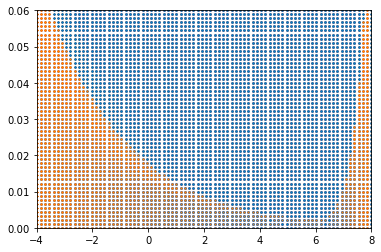

In [4]:
xfoo = size[idx[idx[:,0] > idx[:,2],0]]
yfoo = eccs[idx[idx[:,0] > idx[:,2],1]]
plt.plot(xfoo,yfoo,ls='',marker='o',markersize=.5)
xfoo = size[idx[idx[:,0] < idx[:,2],0]]
yfoo = eccs[idx[idx[:,0] < idx[:,2],1]]
plt.plot(xfoo,yfoo,ls='',marker='o',markersize=.5)
plt.xlim(-4,8)
plt.ylim(0,0.06)
plt.xlabel('log size [cm]')
plt.ylabel('ecc')
plt.show()

Plot showing where we have collisions that have smaller bullets (blue) and where we have ones with bigger ones (orange). Note that the blue area extends beneath the orange.

In [114]:
step = 2000

typical_e_into = np.zeros((gpe,gps))
#maximum_s_into = np.zeros((gpe,gps))
for i in range(gps):
    for n in range(gpe):
        relevant_collisions = np.argwhere((idx[:,0] == i) & (idx[:,1] == n))
        
        numerator = np.sum(esucc_idx[relevant_collisions]*10**nrem_all[step,relevant_collisions])
        denominat = np.sum(10**nrem_all[step,relevant_collisions])
        typical_e_into[n,i] = numerator/denominat

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_58656/1600371551.py:11: RuntimeWarning: invalid value encountered in double_scalars
  typical_e_into[n,i] = numerator/denominat


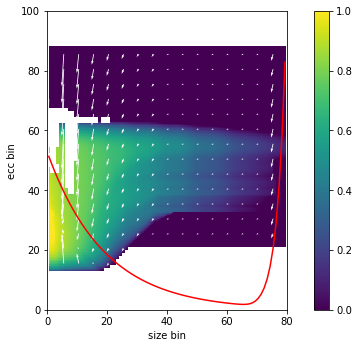

After 16.43 Myr


In [131]:
fig,ax=plt.subplots(figsize=(10,5.5))

sparse_typical_e = typical_e_into[::5,::5]
plt.imshow(N[step],origin='lower',vmin=0,vmax=38,extent=(0.5,79.5,0.5,99.5))
ss,ee = np.meshgrid(np.arange(gps)+.5,np.arange(gpe)+.5)
plt.quiver(ss[::5,::5],ee[::5,::5],np.full((16,20),-1),sparse_typical_e-ee[::5,::5],color='white')
plt.plot(np.arange(gps)+.5,efail*gpe/(e0+.05),c='r')
plt.xlabel('size bin')
plt.ylabel('ecc bin')
plt.xlim(0,gps)
plt.ylim(0,gpe)
plt.colorbar()
plt.savefig('motion_between.png',dpi=300)
plt.show()
print('After %2.2f Myr' %(ts[step]/1e6))

In [6]:
def efault(s):
    """
    - For a given size, defines the minimum e for which a catastrophic collision can occur
    - Assumes both body and bullet have same e
    - If e < efail, 2*Q_star > vcol**2 --> not enough energy to break up
    
    In: s -- float; size, in meters
    Out: efail -- float; min eccentricity
    """
    Q_ = qstar(s)
    efail = np.sqrt(2*Q_)/v_kep
    return efail

efail = efault(size)

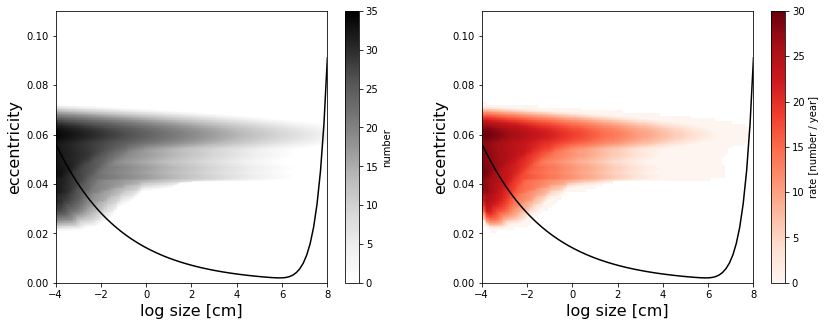

In [97]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
for i in range(2):
    ax[i].set_xlabel('log size [cm]',fontsize=16)
    ax[i].set_ylabel('eccentricity',fontsize=16)
    ax[i].plot(size,efail,c='k')

n_plot = ax[0].imshow(N[10],origin='lower',extent=(sMin,sMax,eMin,eMax),aspect=asp_rat,vmin=-0,vmax=35,cmap='Greys')
fig.colorbar(n_plot,ax=ax[0],label=r'number')

i_plot = ax[1].imshow(N_o[10],origin='lower',extent=(sMin,sMax,eMin,eMax),
                      aspect=asp_rat,vmin=-0,vmax=30,cmap='Reds')
fig.colorbar(i_plot,ax=ax[1],label=r'rate [number / year]')


#ax[0].text(sMax-.5,eMax-.01,'Numbers',fontsize=16,ha='right',va='top')
#ax[1].text(sMax-.5,eMax-.01,'Change',fontsize=16,ha='right',va='top')

#fig.tight_layout()

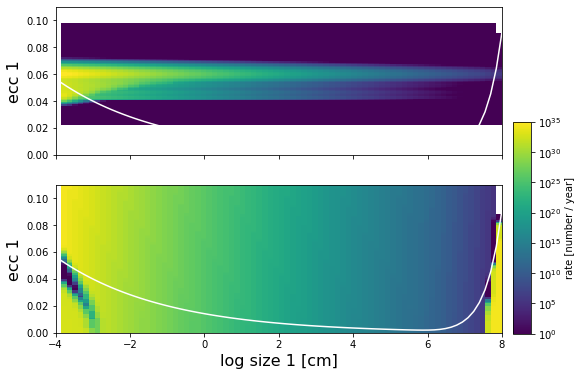

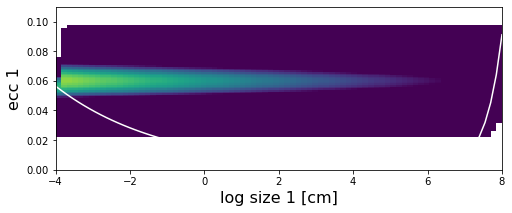

In [95]:
step = 1
vmi = 1
vma = 1e35

fig,ax = plt.subplots(2,figsize=(8,6),sharex=True)

_,_,_,b = ax[0].hist2d(size[idx[idx[:,0]>idx[:,2],0]],eccs[idx[idx[:,0]>idx[:,2],1]],
                       weights=(10**(N[step,
                                       idx[idx[:,0]>idx[:,2],1],
                                       idx[idx[:,0]>idx[:,2],0]])),
                       range=((sMin,sMax),(eMin,eMax)),
                       bins=(gps,gpe),
                       norm=LogNorm(vmin=vmi,vmax=vma))
ax[0].set_ylabel('ecc 1',fontsize=16)


weights2a = 10**(N[step,
                   idx[(idx[:,0]>idx[:,2]),3],
                   idx[(idx[:,0]>idx[:,2]),2]]
                )
weights2b = 10**(N[step,
                   idx[(idx[:,0]>idx[:,2]) & (idx[:,2] != 0),3],
                   idx[(idx[:,0]>idx[:,2]) & (idx[:,2] != 0),2]]
                )
_,_,_,b = ax[1].hist2d(size[idx[(idx[:,0]>idx[:,2]),0]],
                       eccs[idx[(idx[:,0]>idx[:,2]),1]],
                       weights=weights2a,
                       range=((sMin,sMax),(eMin,eMax)),
                       bins=(gps,gpe),
                       norm=LogNorm(vmin=vmi,vmax=vma))
ax[1].set_ylabel('ecc 1',fontsize=16)
ax[1].set_xlabel('log size 1 [cm]',fontsize=16)

for i in range(2):
    ax[i].plot(size,efail,c='white')

#cbar_axa = fig.add_axes([0.92, 0.657, 0.03, 0.223])
#fig.colorbar(a,cax=cbar_axa,label=r'rate [number / year]')

cbar_axb = fig.add_axes([0.92, 0.123, 0.03, 0.49])
fig.colorbar(b,cax=cbar_axb,label=r'rate [number / year]')
#plt.savefig('ev_s1_esucc_rate.png',dpi=300)
plt.show()

fig1,ax1 = plt.subplots(figsize=(8,3))

_,_,_,a = ax1.hist2d(size[idx[:,0]],eccs[idx[:,1]],
                       weights=(10**(R_flat + N[0,idx[:,1],idx[:,0]] + N[0,idx[:,3],idx[:,2]])),
                       range=((sMin,sMax),(eMin,eMax)),
                       bins=(gps,gpe),
                       norm=LogNorm(vmin=vmi,vmax=vma))
ax1.set_ylabel('ecc 1',fontsize=16)
ax1.set_xlabel('log size 1 [cm]',fontsize=16)
ax1.plot(size,efail,c='white')
#cbar_axa = fig.add_axes([0.92, 0.657, 0.03, 0.223])
#fig.colorbar(a,cax=cbar_axa,label=r'rate [number / year]')
plt.show()

- (upper) one-to-one rate of collisions
- (middle up) number of bodies
- (middle lo) number of bullets
- (lower) overall rate of collisions

only looking at collisions where $s_1 > s_2$

In [57]:
step = 100

typical_e_into = np.zeros((gpe,gps))
#maximum_s_into = np.zeros((gpe,gps))
for i in range(gps):
    for n in range(gpe):
        relevant_collisions = np.argwhere((idx[:,0] == i) & (idx[:,1] == n))
        
        numerator = np.sum(esucc_idx[relevant_collisions]*10**nrem_all[step,relevant_collisions])
        denominat = np.sum(10**nrem_all[step,relevant_collisions])
        typical_e_into[n,i] = numerator/denominat

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_58656/641311622.py:11: RuntimeWarning: invalid value encountered in double_scalars
  typical_e_into[n,i] = numerator/denominat


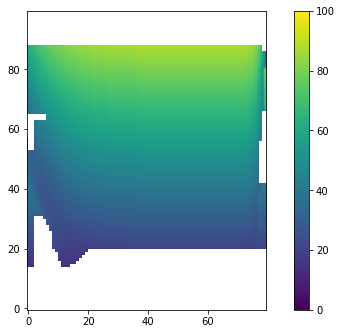

In [65]:
fig,ax=plt.subplots(figsize=(10,5.5))
plt.imshow(typical_e_into,origin='lower',vmin=0,vmax=gpe)
plt.colorbar()

In [86]:
step = 100

typical_bullet_s = np.zeros((gpe,gps))
typical_bullet_e = np.zeros((gpe,gps))
for i in range(gps):
    for n in range(gpe):
        relevant_collisions = np.argwhere((idx[:,0] == i) & (idx[:,1] == n))
        
        numerator = np.nansum(10**G_flat[relevant_collisions]*10**nrem_all[step,relevant_collisions])
        denominat = np.nansum(10**nrem_all[step,relevant_collisions])
        #numerator = np.nansum(10**G_flat[relevant_collisions])
        #denominat = len(relevant_collisions)
        typical_bullet_s[n,i] = np.log10(numerator/denominat)
        
        numerator = np.nansum(idx[relevant_collisions,3]*10**nrem_all[step,relevant_collisions])
        typical_bullet_e[n,i] = (numerator/denominat)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_58656/799057400.py:13: RuntimeWarning: invalid value encountered in double_scalars
  typical_bullet_s[n,i] = np.log10(numerator/denominat)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_58656/799057400.py:13: RuntimeWarning: divide by zero encountered in log10
  typical_bullet_s[n,i] = np.log10(numerator/denominat)


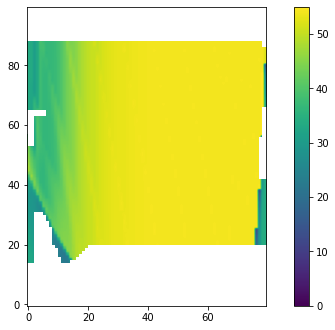

In [92]:
fig,ax=plt.subplots(figsize=(10,5.5))
plt.imshow(typical_bullet_e,origin='lower',vmin=0,vmax=55)
plt.colorbar()

In [29]:
plt.hist(G_flat[relevant_co])

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf])

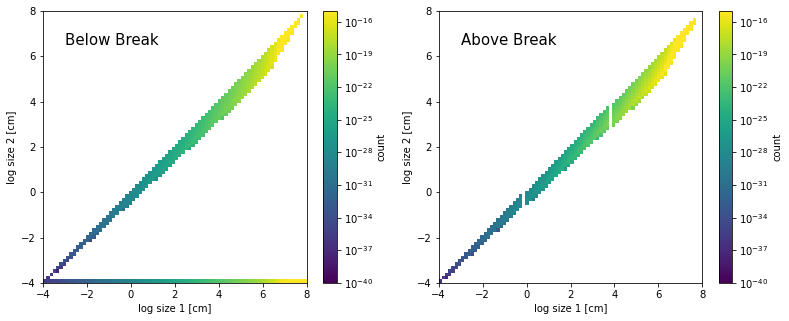

In [179]:
xbelow_foo = size[idx[eccs[idx[:,1]] < efault(size[idx[:,0]]),0]]
ybelow_foo = size[idx[eccs[idx[:,1]] < efault(size[idx[:,0]]),2]]

xabove_foo = size[idx[eccs[idx[:,1]] > efault(size[idx[:,0]]),0]]
yabove_foo = size[idx[eccs[idx[:,1]] > efault(size[idx[:,0]]),2]]

fig,ax=plt.subplots(1,2,figsize=(13,5))

_,_,_,a = ax[0].hist2d(xbelow_foo,ybelow_foo,bins=gps,norm=LogNorm(vmin=1e-40,vmax=1e-15),
                      weights=10**R_flat[eccs[idx[:,1]] < efault(size[idx[:,0]])])
_,_,_,b = ax[1].hist2d(xabove_foo,yabove_foo,bins=gps,norm=LogNorm(vmin=1e-40,vmax=1e-15),
                      weights=10**R_flat[eccs[idx[:,1]] > efault(size[idx[:,0]])])
fig.colorbar(a,ax=ax[0],label='count')
fig.colorbar(b,ax=ax[1],label='count')

ax[0].text(-3,6.5,'Below Break',fontsize=15)
ax[1].text(-3,6.5,'Above Break',fontsize=15)

for i in range(2):
    ax[i].set_xlabel('log size 1 [cm]')
    ax[i].set_ylabel('log size 2 [cm]')
    ax[i].set_xlim(-4,8)
    ax[i].set_ylim(-4,8)

plt.show()